# MSBC5180 HW2 Coding Part: Linear Classification 

### Solution by: Anne Pierce


## Assignment overview

In this assignment, you will build a classifier that tries to infer whether tweets from [@realDonaldTrump](https://twitter.com/realDonaldTrump) were written by Trump himself or by a staff person.
This is an example of binary classification on a text dataset. 

It is known that Donald Trump uses an Android phone, and it has been observed that some of his tweets come from Android while others come from other devices (most commonly iPhone). It is widely believed that Android tweets are written by Trump himself, while iPhone tweets are written by other staff. For more information, you can read this [blog post by David Robinson](http://varianceexplained.org/r/trump-tweets/), written prior to the 2016 election, which finds a number of differences in the style and timing of tweets published under these two devices. (Some tweets are written from other devices, but for simplicity the dataset for this assignment is restricted to these two.)

This is a classification task known as "authorship attribution", which is the task of inferring the author of a document when the authorship is unknown. We will see how accurately this can be done with linear classifiers using word features.

You will need `sklearn` version **1.1.2** for this assignment.

## What to Hand In
You will turn in a completed notebook on Canvas as a ipynb file. Your submission should be contained in a single Jupyter notebook named `hw2-firtname-lastname.ipynb`, where `firstname` and `lastname` are replaced with your first and last names. This will include your code as well as figures and answers to questions. Please create headers for your cells that are labeled “Deliverable” followed by the problem number, so that your responses are easy to find.

## The Associated Quiz
You will complete the associated quiz for HW2 on Canvas. The quiz is name **"Quiz HW2 "**.

## Collaboration policies
You are allowed to work with up to 3 people besides yourself. You are still expected to write up your own solution. Each individual must turn in their own submission, and list your collaborators after your name.

## Asking for Help
You are encouraged to ask questions on the Zoom channel. Do not post anything that you are turning in. In this assignment, that would be any of the plots you need to hand in, or the parameter values. However, you can describe your results, like the number of iterations it took to converge, and general things you observe about the algorithms.
You may ask questions to help with debugging, but do not post your code in a way of giving away solution. You can share error messages and describe what you are trying to do with your code, but try not to write enough to “give away” the solution.


## Getting started

In this assignment, you will experiment with perceptron and logistic regression in `sklearn`. Much of the code has already been written for you. We will use a class called `SGDClassifier` (which you should read about in the [sklearn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)), which  implements stochastic gradient descent (SGD) for a variety of loss functions, including both perceptron and logistic regression, so this will be a way to easily move between the two classifiers.

The code below will load the datasets. There are two data collections: the "training" data, which contains the tweets that you will use for training the classifiers, and the "testing" data, which are tweets that you will use to measure the classifier accuracy. The test tweets are instances the classifier has never seen before, so they are a good way to see how the classifier will behave on data it hasn't seen before. However, we still know the labels of the test tweets, so we can measure the accuracy.

For this problem, we will use what are called "bag of words" features, which are commonly used when doing classification with text. Each feature is a word, and the value of a feature for a particular tweet is number of times the word appears in the tweet (with value $0$ if the word does not appear in the tweet).

Run the block of code below to load the data. You don't need to do anything yet. Move on to "Problem 1" next.

In [39]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#training set
df_train = pd.read_csv('tweets.train.tsv', sep='\t', header=None)

Y_train = df_train.iloc[0:, 0].values
text_train = df_train.iloc[0:, 1].values

vec = CountVectorizer()
X_train = vec.fit_transform(text_train)
feature_names = np.asarray(vec.get_feature_names())

#testing set
df_test = pd.read_csv('tweets.test.tsv', sep='\t', header=None)
Y_test = df_test.iloc[0:, 0].values
text_test = df_test.iloc[0:, 1].values

X_test = vec.transform(text_test)


/Users/test/opt/anaconda3/envs/MLP22-2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Problem 1: Understand the data

Before doing anything else, take time to understand the code above.

The variables `df_train` and `df_test` are dataframes that store the training (and testing) datasets, which are contained in tab-separated files where the first column is the label and the second column is the text of the tweet.

The [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class converts the raw text into a bag-of-words into a feature vector representation that `sklearn` can use.

You should print out the values of the variables and write any other code needed to answer the following questions.

#### Deliverable 1.1: How many training instances are in the dataset? How many test instances?

train - 2593; test - 185. See code below for showing how I found that answer.

In [40]:
number_of_train = df_train.count()[0]
number_of_test = df_test.count()[0]
print(f"There are {number_of_train} training samples and {number_of_test} testing samples")
# there are 2593 instances

There are 2593 training samples and 185 testing samples


#### Deliverable 1.2: How many features are in the training data?

[There are 4829 features. I learned this by using the CountVectorization function (see code in cell below) and saw there are 4829 unique words.]

In [41]:
words = df_train[1]
vectorizer = CountVectorizer()

featureCount = vectorizer.fit_transform(words)
featureCount

<2593x4829 sparse matrix of type '<class 'numpy.int64'>'
	with 40618 stored elements in Compressed Sparse Row format>

#### Deliverable 1.3: What is the distribution of labels in the training data? That is, what percentage of instances are 'Android' versus 'iPhone'?

[51.63902815271886 percent of instances are Android and 48.36097184728114 percent of instances are iPhone. See cell below for the code I used to find that answer.]

In [42]:
percent_android=(1339/2593)*100
percent_iphone=((2593-1339)/2593)*100
print(f"{percent_android} percent of instances are Android and {percent_iphone} percent of instances are iPhone")

51.63902815271886 percent of instances are Android and 48.36097184728114 percent of instances are iPhone


## Problem 2: Perceptron

The code below trains an [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) using the perceptron loss, then it measures the accuracy of the classifier on the test data, using `sklearn`'s [`accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function. 

The `fit` function trains the classifier. The feature weights are stored in the `coef_` variable after training. The `predict` function of the trained `SGDClassifier` outputs the predicted label for a given instance or list of instances.

Additionally, this code displays the features and their weights in sorted order, which you may want to examine to understand what the classifier is learning. In this dataset, the $\textrm{Android}$ class is considered the "negative" class because it comes first in the data.

There are 3 keyword arguments that have been added to the code below. It is important you keep the same values of these arguments whenever you create an `SGDClassifier` instance in this assignment so that you get consistent results. They are:

- `max_iter` is one of the stopping criteria, which is the maximum number of iterations/epochs the algorithm will run for.

- `tol` is the other stopping criterion, which is how small the difference between the current loss and previous loss should be before stopping.

- `random_state` is a seed for pseudorandom number generation. The algorithm uses randomness in the way the training data are sorted, which will affect the solution that is learned, and even the accuracy of that solution.

Wait a minute $-$ in class we learned that the loss function is convex, so the algorithm will find the same minimum regardless of how it is trained. Why is there random variation in the output? The reason is that even though there is only one minimum value of the loss, there may be different weights that result in the same loss, so randomness is a matter of tie-breaking. What's more, while different weights may have the same loss, they could lead to different classification accuracies, because the loss function is not the same as accuracy. (Unless accuracy was your loss function... which is possible, but uncommon because it turns out to be a difficult function to optimize.)

Note that different computers may still give different answers, despite keeping these settings the same, because of how pseudorandom numbers are generated with different operating systems and Python environments. 

To begin, run the code in the cell below without modification.

#### Deliverable 2.1: Based on the training accuracy, do you conclude that the data are linearly separable? Why or why not?

[No the data is not completely linearly separable because the accuracy is not 100%.]

#### Deliverable 2.2: Which feature most increases the likelihood that the class is 'Android' and which feature most increases the likelihood that the class is 'iPhone'? 

[The feature that most increases the likelihood that the class is Android is "00" and the second feature most likely to push to Android class is "veterans". The feature that most likely increases the likelihood that the class is iPhone is "imwithyou". We can determine this because veterans is the highest negative weight whereas imwithyou is the highest positive weight. Since Android is the negative class and iPhone is the positive class, these features are most likely increasing the likelihood as being classified to their respective classes.]

<br />



In [43]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score

classifier = SGDClassifier(loss='perceptron', max_iter=1000, tol=1.0e-12, random_state=123, eta0=100)
classifier.fit(X_train, Y_train)

print("Number of SGD iterations: %d" % classifier.n_iter_)
print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier.predict(X_train)))
print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

print("\nFeature weights:")
args = np.argsort(classifier.coef_[0])
for a in args:
    print(" %s: %0.4f" % (feature_names[a], classifier.coef_[0][a]))

Number of SGD iterations: 38
Training accuracy: 0.997300
Testing accuracy: 0.864865

Feature weights:
 00: -1.5070
 veterans: -1.2056
 wow: -1.2056
 talking: -1.1052
 called: -1.1052
 badly: -1.0047
 into: -1.0047
 stay: -0.9042
 actually: -0.9042
 hillaryclinton: -0.9042
 woman: -0.9042
 talks: -0.9042
 look: -0.9042
 weak: -0.8038
 mails: -0.8038
 illegals: -0.8038
 standing: -0.8038
 allowed: -0.8038
 care: -0.8038
 making: -0.8038
 spent: -0.8038
 donaldtrump: -0.8038
 sources: -0.8038
 wrong: -0.8038
 cruz: -0.7033
 reported: -0.7033
 scared: -0.7033
 frontrunner: -0.7033
 expensive: -0.7033
 four: -0.7033
 game: -0.7033
 old: -0.7033
 oregon: -0.7033
 use: -0.7033
 mr: -0.7033
 order: -0.7033
 texas: -0.7033
 charge: -0.7033
 reviews: -0.7033
 statement: -0.7033
 _username_: -0.7033
 taking: -0.6028
 fake: -0.6028
 presumptive: -0.6028
 turned: -0.6028
 sigh: -0.6028
 read: -0.6028
 teleprompter: -0.6028
 tim: -0.6028
 doesn: -0.6028
 isn: -0.6028
 many: -0.6028
 senator: -0.6028

One technique for improving the resulting model with perceptron (or stochastic gradient descent learning in general) is to take an average of the weight vectors learned at different iterations of the algorithm, rather than only using the final weights that minimize the loss. That is, calculate $\bar{\mathbf{w}} =\frac{ \sum_{t=1}^T \mathbf{w}^{(t)}}{T}$ where $\mathbf{w}^{(t)}$ is the weight vector at iteration $t$ of the algorithm and $T$ is the number of iterations, and then use $\bar{\mathbf{w}}$ when making classifications on new data.

To use this technique in your classifier, add the keyword argument `average=True` to the `SGDClassifier` function. Try it now.

#### Deliverable 2.3: Compare the initial training/test accuracies to the training/test accuracies after doing averaging. What happens? Why do you think averaging the weights from different iterations has this effect?

[The training accurracy decreases slightly and the test accuracy increase slightly. Averaging the weights from different iterations would have this effect because instead of using the weights that minimize the loss, you are using the average weight. Thus this would decrease the accurancy of the training data set because you are not using the weights optimal for that training data set. However, it would increase the accuracy of the test data because by using the average you are creating a model with more bias but less varience, thus preventing overfitting. This is ideal here because the goal is to increase the test data set accurancy.]



In [44]:
classifier = SGDClassifier(loss='perceptron', max_iter=1000, tol=1.0e-12, average=True, random_state=123, eta0=100)
classifier.fit(X_train, Y_train)

print("Number of SGD iterations: %d" % classifier.n_iter_)
print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier.predict(X_train)))
print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

print("\nFeature weights:")
args = np.argsort(classifier.coef_[0])
for a in args:
    print(" %s: %0.4f" % (feature_names[a], classifier.coef_[0][a]))

Number of SGD iterations: 38
Training accuracy: 0.991901
Testing accuracy: 0.870270

Feature weights:
 00: -4.5806
 badly: -3.2071
 wow: -3.1911
 into: -2.8277
 veterans: -2.8077
 called: -2.8060
 allowed: -2.6492
 wrong: -2.5710
 talks: -2.5606
 look: -2.5503
 talking: -2.4765
 donaldtrump: -2.4097
 woman: -2.3328
 big: -2.3324
 _username_: -2.2442
 stay: -2.1913
 care: -2.1731
 spent: -2.0471
 game: -2.0240
 weak: -2.0128
 coming: -1.9943
 sources: -1.9925
 standing: -1.9737
 statement: -1.9714
 hillaryclinton: -1.9713
 actually: -1.9649
 mails: -1.9594
 many: -1.9147
 making: -1.9088
 charge: -1.9046
 crooked: -1.8739
 trump: -1.8317
 policy: -1.8185
 mr: -1.7518
 isn: -1.7460
 old: -1.7428
 reviews: -1.7173
 senator: -1.7053
 cruz: -1.6973
 own: -1.6674
 texas: -1.6663
 such: -1.6586
 illegals: -1.6547
 frontrunner: -1.6479
 would: -1.6448
 expensive: -1.6348
 wonder: -1.6305
 their: -1.6237
 scared: -1.6069
 praised: -1.5983
 oregon: -1.5975
 that: -1.5968
 being: -1.5954
 call: -

## Problem 3: Logistic regression [15 points]

For this problem, create a new `SGDClassifier`, this time setting the `loss` argument to `'log_loss'`, which will train a logistic regression classifier. Set `average=False` for the remaining problems.

Once you have trained the classifier, you can use the `predict` function to get the classifications, as with perceptron. Additionally, logistic regression provides probabilities for the predictions. You can get the probabilities by calling the `predict_proba` function. This will give a list of two numbers; the first is the probability that the class is $\textrm{Android}$ and the second is the probability that the class is $\textrm{iPhone}$.


For the first task, add the keyword argument `alpha` to the `SGDClassifier` function. This is the regularization strength, called $\lambda$ in lecture. If you don't specify `alpha`, it defaults to $0.0001$. Experiment with other values and see how this affects the outcome.

#### Deliverable 3.1: Calculate the training and testing accuracy when `alpha` is one of $[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]$. Create a plot where the x-axis is `alpha` and the y-axis is accuracy, with two lines (one for training and one for testing). You can borrow the code from HW1 for generating plots in Python. Use [a log scale for the x-axis](https://matplotlib.org/examples/pylab_examples/log_demo.html) so that the `alpha` values are spaced evenly. `plt.semilogx()` is the function you should use if you import `matplotlib.pyplot` as `plt`.

[My solution is plotted below]



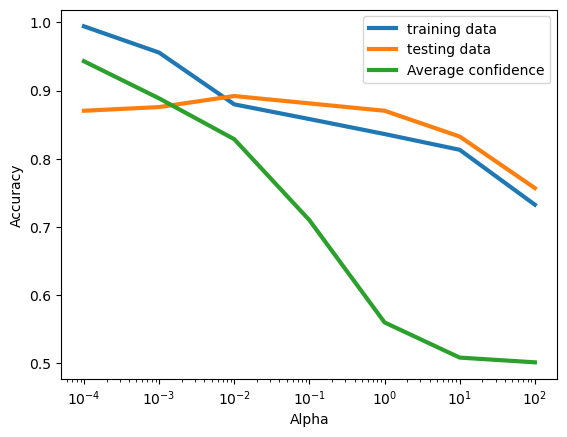

In [45]:
import matplotlib.pyplot as plt
import numpy as np

train_vals = []
test_vals = []
probability_vals = []
alphas = []
alpha = 0.0001
for i in range(7):
    classifier = SGDClassifier(loss='log_loss', alpha=alpha, max_iter=1000, tol=1.0e-12, average=False, random_state=123, eta0=100)
    classifier.fit(X_train, Y_train)
    # get scores
    train_score = accuracy_score(Y_train, classifier.predict(X_train))
    test_score = accuracy_score(Y_test, classifier.predict(X_test))
    max_proba = np.average([max(row) for row in classifier.predict_proba(X_test)])
    # store scores
    train_vals.append(train_score)
    test_vals.append(test_score)
    probability_vals.append(max_proba)
    alphas.append(alpha)
    # update to new alpha
    alpha *= 10
    

plt.semilogx(alphas, train_vals, label="training data", linewidth=3)
plt.semilogx(alphas, test_vals, label="testing data", linewidth=3)
plt.semilogx(alphas, probability_vals, label="Average confidence", linewidth=3)
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.legend()

#### Deliverable 3.2: Examine the classifier probabilities using the `predict_proba` function when training with different values of `alpha`. You can examine the first test instance for this. What do you observe? How does `alpha` affect the prediction probabilities, and why do you think this happens?

[In the plot above, I included the max probability which decreases to ~50% as you increase the alpha. Since there are only 2 classes this means the predict probability gets closer to random chance as you increase the alpha. This occurs because when you further increase alpha, you are making your weights closer and closer to 0. When you do this, your model then is very poor because all features have very low weights and essentially cannot contriute to the model.]

<br />

Now remove the `alpha` argument so that it goes back to the default value. We'll now look at the effect of the learning rate. By default, `sklearn` uses an "optimal" learning rate based on some heuristics that work well for many problems. However, it can be good to see how the learning rate can affect the algorithm.

For this task, add the keyword argument `learning_rate` to the `SGDClassifier` function and set the value to `invscaling`. This defines the learning rate at iteration $t$ as: $\eta_t = \frac{\eta_0}{t^a}$, where $\eta_0$ and $a$ are both arguments you have to define in the `SGDClassifier` function, called `eta0` and `power_t`, respectively. Experiment with different values of `eta0` and `power_t` and see how they affect the number of iterations it takes the algorithm to converge. You will often find that it will not finish within the maximum of $1000$ iterations.



In [46]:
for eta_val in [10.0, 100.0, 1000.0, 10000.0]:
    for powert_val in [0.5, 1.0, 2.0]:
        classifier = SGDClassifier(loss='log_loss', learning_rate='invscaling', power_t=powert_val, max_iter=1000, tol=1.0e-12, average=False, random_state=123, eta0=eta_val)
        classifier.fit(X_train, Y_train)
        iterations = classifier.n_iter_
        print(f"| ${eta_val}$    | ${powert_val}$     |     ${iterations}$         |")

| $10.0$    | $0.5$     |     $96$         |


/Users/test/opt/anaconda3/envs/MLP22-2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


| $10.0$    | $1.0$     |     $1000$         |


/Users/test/opt/anaconda3/envs/MLP22-2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


| $10.0$    | $2.0$     |     $1000$         |
| $100.0$    | $0.5$     |     $15$         |


/Users/test/opt/anaconda3/envs/MLP22-2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


| $100.0$    | $1.0$     |     $1000$         |


/Users/test/opt/anaconda3/envs/MLP22-2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


| $100.0$    | $2.0$     |     $1000$         |
| $1000.0$    | $0.5$     |     $45$         |


/Users/test/opt/anaconda3/envs/MLP22-2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


| $1000.0$    | $1.0$     |     $1000$         |


/Users/test/opt/anaconda3/envs/MLP22-2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


| $1000.0$    | $2.0$     |     $1000$         |
| $10000.0$    | $0.5$     |     $40$         |
| $10000.0$    | $1.0$     |     $14$         |
| $10000.0$    | $2.0$     |     $1000$         |


/Users/test/opt/anaconda3/envs/MLP22-2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


#### Deliverable 3.3: Fill in the table below with the number of iterations for values of `eta0` in $[10.0, 100.0, 1000.0, 10000.0]$ and values of `power_t` in $[0.5, 1.0, 2.0]$. You may find it easier to write python code that can output the markdown for the table, but if you do that place the output here. If it does not converge within the maximum number of iterations (set to $1000$ by `max_iter`), record $1000$ as the number of iterations.

| `eta0`   | `power_t` | # Iterations |
|-----------|-----------|--------------|
| $10.0$    | $0.5$     |     $96$         |
| $10.0$    | $1.0$     |     $1000$         |
| $10.0$    | $2.0$     |     $1000$         |
| $100.0$    | $0.5$     |     $15$         |
| $100.0$    | $1.0$     |     $1000$         |
| $100.0$    | $2.0$     |     $1000$         |
| $1000.0$    | $0.5$     |     $45$         |
| $1000.0$    | $1.0$     |     $1000$         |
| $1000.0$    | $2.0$     |     $1000$         |
| $10000.0$    | $0.5$     |     $40$         |
| $10000.0$    | $1.0$     |     $14$         |
| $10000.0$    | $2.0$     |     $1000$         |
#### Deliverable 3.4: Describe how `eta0` and `power_t` affect the learning rate based on the formula (e.g., if you increase `power_t`, what will this do to the learning rate?), and connect this to what you observe in the table above.

[code is in the cell above. If you increase power_t, this increased the denominator, thus making the learning rate smaller. You are taking smaller steps which is why you never converge befoer reaching the maximum number of iterations.]
   
<br />



Now remove the `learning_rate`, `eta0`, and `power_t` arguments so that the learning rate returns to the default setting. For this final task, we will experiment with how high the probabiity must be before an instance is classified as positive.

The code below includes a function called `threshold` which takes as input the classification probabilities of the data (called `probs`, which is given by the function `predict_proba`) and a threshold (called `tau`, a scalar that should be a value between $0$ and $1$). It will classify each instance as $\textrm{Android}$ if the probability of being $\textrm{Android}$ is greater than `tau`, otherwise it will classify the instance as $\textrm{iPhone}$. Note that if you set `tau` to $0.5$, the `threshold` function should give you exactly the same output as the classifier `predict` function.

You should find that increasing the threshold causes the accuracy to drop. This makes sense, because you are classifying some things as $\textrm{iPhone}$ even though it's more probable that they are $\textrm{Android}$. So why do this? Suppose you care more about accurately identifying the $\textrm{Android}$ tweets and you don't care as much about `iPhone` tweets. You want to be confident that when you classify a tweet as $\textrm{Android}$ that it really is $\textrm{Android}$.

There is a metric called _precision_ which measures something like accuracy but for one specific class. Whereas accuracy is the percentage of tweets that were correctly classified, the precision of $\textrm{Android}$ would be the percentage of tweets classified as $\textrm{Android}$ that were correctly classified. (In other words, the number of tweets classified as $\textrm{Android}$ whose correct label was $\textrm{Android}$, divided by the number of tweets classified as $\textrm{Android}$.)

You can use the [`precision_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) function from `sklearn` to calculate the precision. It works just like the `accuracy_score` function, except you have to add an additional keyword argument, `pos_label='Android'`, which tells it that $\textrm{Android}$ is the class you want to calculate the precision of.
#### Deliverable 3.5: Calculate the testing precision when the value of `tau` for thresholding is one of $[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]$. Create a plot where the x-axis is `tau` and the y-axis is precision.

[My solution is plotted below]


Text(0, 0.5, 'Precision')

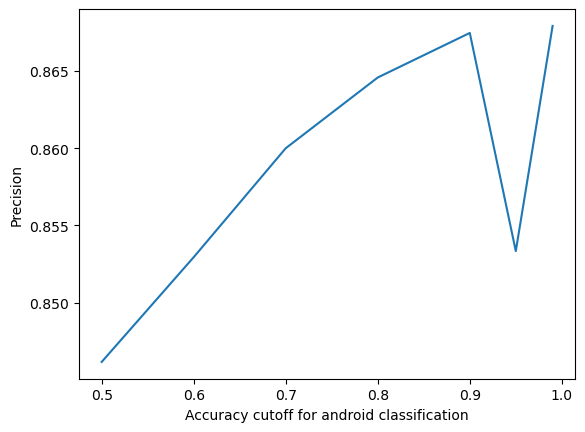

In [47]:
from sklearn.metrics import precision_score
# use this function for deliverable 3.5
def threshold(probs, tau):
    return np.where(probs[:,0] > tau, 'Android', 'iPhone')

# your logistic regression code here
precision_array = []
tau_array = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
for tau in tau_array:
    classifier = SGDClassifier(loss='log_loss', max_iter=1000, tol=1.0e-12, random_state=123)
    classifier.fit(X_train, Y_train)
    probs = classifier.predict_proba(X_test)
    predictions = threshold(probs, tau)
    precision = precision_score(Y_test, predictions, pos_label='Android')
    precision_array.append(precision)
    
plt.plot(tau_array, precision_array)
plt.xlabel("Accuracy cutoff for android classification")
plt.ylabel("Precision")


#### Deliverable 3.6: Describe what you observe with thresholding (e.g., what happens to precision as the threshold increases?), and explain why you think this happens.

[Generally, as your tau or threshold increases, your precision score increases. This is because you are saying that you must have a high probability, and thus, higher certainity that it is a tweet from trump in order to classifiy it as an Android.]

## Problem 4: Sparse learning 

Add the `penalty` argument to `SGDClassifier` and set the value to `'l1'`, which tells the algorithm to use L1 regularization instead of the default L2. Recall from lecture that L1 regularization encourages weights to stay at exactly $0$, resulting in a more "sparse" model than L2. You should see this effect if you examine the values of `classifier.coef_`. We are still doing logistic regression here.

#### Deliverable 4.1: Write a function to calculate the number of features whose weights are nonzero when using L1 regularization. Calculate the number of nonzero feature weights when `alpha` is one of $[0.00001, 0.0001, 0.001, 0.01, 0.1]$. Create a plot where the x-axis is `alpha` and the y-axis is the number of nonzero weights, using a log scale for the x-axis.

[My solution is plotted below.]

-638.9569424341958
1308
47.28132321934321
874
-2.4405020410537417
71
0.2589850532547314
1
0.5576899846272909
1


Text(0.5, 0, 'Alpha')

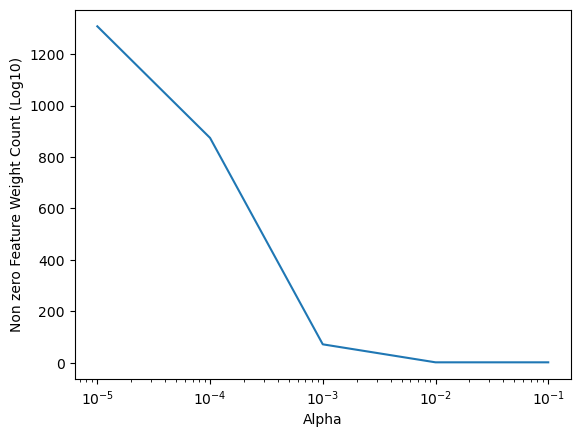

In [48]:
alpha_array = [0.00001, 0.0001, 0.001, 0.01, 0.1]
zeros = []
for alpha in alpha_array:
    classifier = SGDClassifier(loss='log_loss', penalty='l1', alpha=alpha, max_iter=1000, tol=1.0e-12, random_state=123)
    classifier.fit(X_train, Y_train)
    # count zeros
    zero_count = sum([1 for i in classifier.coef_[0] if i > 0])
    print(sum(classifier.coef_[0]))
    print(zero_count)
    zeros.append(zero_count)

plt.semilogx(alpha_array, zeros)
plt.ylabel("Non zero Feature Weight Count (Log10)")
plt.xlabel("Alpha")

In [19]:
# Using l1 regularization, you have a lot of features that have a value of zero as you increase alpha.